In [1]:
import uuid
import lightgbm as lgb
from scipy import special
import numpy as np
import pandas as pd
from collections import OrderedDict
from functools import lru_cache 
from datetime import date, datetime, timedelta
from zenquant.trader.database import get_database
from zenquant.trader.constant import Interval
from zenquant.trader.object import  OrderData, TradeData, BarData, TickData
from zenquant.ctastrategy.base import (
    STOPORDER_PREFIX,
    StopOrder,
    StopOrderStatus,
    INTERVAL_DELTA_MAP
)
from zenquant.trader.constant import (
    Status,
    Direction,
    Offset,
    Exchange
)
import gym
from zenquant.trader.utility import  round_to
from zenquant.feed.data import BarDataFeed,TickDataFeed 
from zenquant.feed.portfolio import PortfolioDataStream,NetPortfolioDataStream
from zenquant.env.action import ContinueAction 
from zenquant.env.observer import Observer
from zenquant.env.reward import Reward 
from zenquant.env.stopper import Stopper
from zenquant.env.informer import Informer
from zenquant.env.renender import BarRenderer
from zenquant.utils.get_indicators_info import (
    get_bar_level_indicator_info,
    get_tick_level_indicator_info
)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-6)

class ContinueEnv(gym.Env):
    """
    A trading environment made for use with Gym-compatible reinforcement
    learning algorithms with continue actions.
    Parameters
    ----------
    """
    def __init__(self):
        self.clock_step = 0 
        self.if_discrete = False
        self.agent_id = 0    ## updated by agent 
        self.env_num  = 0    ## updated by agent 
        self.target_return = 10 
        self.env_name = "ContinueEnv"
        self.episode_id = 0
        self.tick: TickData
        self.bar: BarData
        self.datetime = None
        self.last_price = 6000  ##division by zero
        self.interval = None
        self.min_step = 250

        self.history_data = []
        #history 
        self.history_action = 0
        self.history_pnl = 0

        self.stop_order_count = 0
        self.stop_orders = {}
        self.active_stop_orders = {}

        self.limit_order_count = 0
        self.limit_orders = {}
        self.active_limit_orders = {}

        self.trade_count = 0
        self.trades = OrderedDict()
    def on_init(self,**kwargs):
        '''
        init basic components  of environments 
        read data and load data 
        '''
        ##parameters for environments

        self.gateway_name = kwargs.get("gateway_name","CryptoBacktest")
        self.mode = kwargs.get('mode',"bar") 
        self.vt_symbol = kwargs.get("vt_symbol", "BTCUSDT.BINANCE")
        self.interval = Interval( kwargs.get("interval","1m"))
        self.min_step = kwargs.get("min_step",250)
        self.symbol = kwargs.get("symbol", "BTC/USDT")
        self.exchange= kwargs.get("exchange",Exchange.BINANCE) 

        self.start = kwargs.get("start", datetime(2021, 9, 1))
        self.end = kwargs.get("end", datetime.now())
        ##parmaeters for environments' components
        ##portfolio
        self.MarginLevel= kwargs.get("MarginLevel", 1)
        self.risk_free = kwargs.get("risk_free", 0)
        self.capital =kwargs.get("capital", 100000)
        self.commission_rate = kwargs.get("commission_rate",0.0)
        self.slippage_rate = kwargs.get("slippage_rate ",0.0)
        ##Action 
        self.action_dim = kwargs.get("action_dim",1) 
        self.pricetick = kwargs.get("pricetick", 0.01)
        self.min_volume = kwargs.get("min_volume", 0.001)
        self.min_trade_balance = kwargs.get("min_trade_balance", 5)
        self.limit_total_margin_rate = kwargs.get("limit_total_margin_rate", 0.5)
        self.available_change_percent= kwargs.get("available_change_percent", 0.5)
        self.skip_mode = kwargs.get("skip_mode", "sma") 
        self.sma_window = kwargs.get("sma_window", 10)
        self.atr_window = kwargs.get("atr_window", 14) 
        self.boll_window = kwargs.get("boll_window", 18)
        self.boll_dev = kwargs.get("boll_dev", 3.4)
        self.holding_pos_mode = kwargs.get("holding_pos_mode", "net")
        self.use_stop = kwargs.get("use_stop", False)
        ##Observer 
        self.pos_info_scale = kwargs.get("pos_info_scale", 2**-7)
        self.indicator_info_scale = kwargs.get("indicator_info_scale", 2**-8)
        self.history_action_scale = kwargs.get("history_action_scale", 2**-7)
        self.history_pnl_scale = kwargs.get("history_pnl_scale", 2**-8)
        self.state_dim= kwargs.get("state_dim", 3)
        self.windows_size = kwargs.get("windows_size", 5) 
        self.indicator_windows_list = kwargs.get("indicator_windows_list",[10,20,40,80])
        ##Rewarder 
        self.lag_window = kwargs.get("lag_window", 5)  
        self.extra_reward = kwargs.get("extra_reward", 0.001) 
        self.survive_reward_scale = kwargs.get("survive_reward_scale", 0.001) 
        self.reward_mode = kwargs.get("reward_mode", "differential_sharpe_ratio") 
        ##Stopper  and Informer
        self.max_allowed_loss = kwargs.get("max_allowed_loss", 0.05) 
        ##traning params
        self.profit_stop_rate = kwargs.get("profit_stop_rate", 1)
        self.loss_stop_rate = kwargs.get("loss_stop_rate", -0.5) 
        self.threshold = kwargs.get("threshold",0.43)
        ##Renender(by **kwargs)
        
        ##load data  to history_data
        self.load_data() 
        self.max_step= len(self.history_data) -1 
        #update datafeed and update indicators' info 
        if self.mode == "bar":
            self.datafeed = BarDataFeed(len(self.history_data))
            for idx,bar in enumerate(self.history_data):
                self.datafeed.update_by_index(idx,bar) 
            self.indicator_array = get_bar_level_indicator_info(self.datafeed,self.indicator_windows_list)
            self.atr_array = self.datafeed.atr(self.atr_window,array = True)
            self.sma_array = self.datafeed.sma(self.sma_window,array = True)
            self.boll_up,self.boll_down = self.datafeed.boll(self.boll_window,self.boll_dev,array = True)
        elif self.mode == "tick":
            self.datafeed = TickDataFeed(len(self.history_data))
            for idx,tick  in enumerate(self.history_data):
                self.datafeed.update_by_index(idx,tick) 
            self.indicator_array = get_tick_level_indicator_info(self.datafeed,self.indicator_windows_list)
            self.atr_array = self.datafeed.atr(self.atr_window,array = True)
            self.sma_array = self.datafeed.sma(self.sma_window,array = True)
            self.boll_up,self.boll_down = self.datafeed.boll(self.boll_window,self.boll_dev,array = True)
        else:
            raise NotImplementedError  
        ##创建组件

        if self.holding_pos_mode == "net":
            self.state_dim= len(self.indicator_array) + 5
        else:
            self.state_dim= len(self.indicator_array) + 9
            ##component
        if self.holding_pos_mode == "net":
            self.portfolio = NetPortfolioDataStream(self)
        else:
            self.portfolio = PortfolioDataStream(self)
        self.action = ContinueAction(self)
        self.observer = Observer(self.state_dim,self.windows_size)
        self.rewarder = Reward(reward_mode=self.reward_mode)
        self.stopper = Stopper(self.max_allowed_loss)
        self.informer = Informer() 
        self.renderer = BarRenderer()

        ##check if min_step is ok
        self.indicator_info = np.array([item[self.min_step] for item in self.indicator_array])
        while np.isnan(self.indicator_info).any():
            self.min_step += 1
            self.indicator_info = np.array([item[self.min_step] for item in self.indicator_array])
        ##update  to min_step 

        self.clock_step = self.min_step
        self.portfolio.clock_step = self.min_step
        self.action.clock_step = self.min_step
        self.observer.clock_step = self.min_step
        self.rewarder.clock_step = self.min_step
        self.stopper.clock_step = self.min_step
        self.informer.clock_step = self.min_step
        if self.mode == "bar":
            self.last_price = self.datafeed.close_array[self.clock_step]
        elif self.mode == "tick":
            self.last_price = self.datafeed.last_price_array[self.clock_step]
        self.portfolio.occupy_rate = 0 
        if self.holding_pos_mode == "net":
            self.portfolio.pos_occupy_rate = 0
            self.portfolio.pos_avgprice = self.last_price 
            self.pos_info =  np.array([self.portfolio.occupy_rate,
            abs(self.portfolio.pos)>self.min_volume,
            1.0-self.portfolio.pos_avgprice/self.last_price])
        else:
            self.portfolio.long_pos_occupy_rate = 0
            self.portfolio.short_pos_occupy_rate = 0 
            self.portfolio.long_pos_avgprice = self.last_price 
            self.portfolio.short_pos_avgprice = self.last_price
            self.pos_info = np.array([self.portfolio.long_pos_occupy_rate ,
                                  self.portfolio.short_pos_occupy_rate,
                                  self.portfolio.occupy_rate,     #long+short+locked 
                                  self.portfolio.long_pos>self.min_volume,
                                  self.portfolio.short_pos>self.min_volume,
                                  1.0-self.portfolio.long_pos_avgprice/self.last_price,
                                  self.portfolio.short_pos_avgprice/self.last_price-1.0])   

        self.indicator_info = np.array([item[self.clock_step] for item in self.indicator_array])
        ## update info  for agent 
        self.pos_info = self.pos_info * self.pos_info_scale 
        self.pos_info = np.hstack([self.pos_info,self.history_action,self.history_pnl])
        self.indicator_info = self.indicator_info * self.indicator_info_scale
        self.init_observation = self.observer.observe(self.indicator_info,self.pos_info).reshape((-1,)) 
        
        ## update info  for agent 
        self.observation_space = self.observer.observation_space
        self.action_space = self.action.action_space 
    def load_data(self):
        """"""
        self.output("开始加载历史数据")

        if not self.end:
            self.end = datetime.now()

        if self.start >= self.end:
            self.output("起始日期必须小于结束日期")
            return
        self.history_data.clear()       # Clear previously loaded history data

        # Load 30 days of data each time and allow for progress update
        total_days = (self.end - self.start).days
        progress_days = max(int(total_days / 10), 1)
        progress_delta = timedelta(days=progress_days)
        interval_delta = INTERVAL_DELTA_MAP[self.interval]

        start = self.start
        end = self.start + progress_delta
        progress = 0

        while start < self.end:
            progress_bar = "#" * int(progress * 10 + 1)
            self.output(f"加载进度：{progress_bar} [{progress:.0%}]")

            end = min(end, self.end)  # Make sure end time stays within set range

            if self.mode == "bar":
                data = load_bar_data(
                    self.symbol,
                    self.exchange,
                    self.interval,
                    start,
                    end
                )
            else:
                data = load_tick_data(
                    self.symbol,
                    self.exchange,
                    start,
                    end
                )

            self.history_data.extend(data)

            progress += progress_days / total_days
            progress = min(progress, 1)

            start = end + interval_delta
            end += progress_delta

        self.output(f"历史数据加载完成，数据量：{len(self.history_data)}")

    def step(self):
         ##create pd
        df = pd.DataFrame([])
        df["time"]=self.datafeed.datetime_array
        df["high"]=self.datafeed.high
        df["low"]=self.datafeed.low
        df["open"]=self.datafeed.open
        df["close"]=self.datafeed.close
        df["volume"]=self.datafeed.volume
        df["atr"] = self.atr_array 
        df=self.create_label(df)
        for i in range(len(self.indicator_array)):
            df[str(i)]=self.indicator_array[i]
        return  df
        
        
        
    def create_label(self,df):
        zigzags = []
        ATR_MULTIPILIER=self.boll_dev
        def calc_change_since_pivot(row, key):
            current = row[key]
            last_pivot = zigzags[-1]["Value"]
            if(last_pivot == 0): last_pivot = 1 ** (-100) # avoid division by 0
            perc_change_since_pivot = (current - last_pivot) / abs(last_pivot)
            return perc_change_since_pivot

        def get_zigzag(row, taip=None):
            if(taip == "Peak"): key = "high"
            elif(taip == "Trough"): key = "low"
            else: key = "close"

            return {
                "Time": row["time"],
                "Value": row[key],
                "Type": taip 
            }
        for ix, row in df.iterrows():
            threshold = row['atr'] / row["open"] * ATR_MULTIPILIER
            # handle first point
            is_starting = ix == 0
            if(is_starting):
                zigzags.append(get_zigzag(row))
                continue

            # handle first line
            is_first_line = len(zigzags) == 1
            if(is_first_line):
                perc_change_since_pivot = calc_change_since_pivot(row, "close")

                if(abs(perc_change_since_pivot) >= threshold):
                    if(perc_change_since_pivot > 0):
                        zigzags.append(get_zigzag(row, "Peak"))
                        zigzags[0]["Type"] = "Trough"
                    else: 
                        zigzags.append(get_zigzag(row, "Trough"))
                        zigzags[0]["Type"] = "Peak"
                continue
    
            # handle other lines
            is_trough = zigzags[-2]["Value"] > zigzags[-1]["Value"]
            is_ending = ix == len(df.index) - 1
            last_pivot = float(zigzags[-1]["Value"])
            # based on last pivot type, look for reversal or continuation
            if(is_trough):
                perc_change_since_pivot = calc_change_since_pivot(row, "high")
                is_reversing = (perc_change_since_pivot >= threshold) or is_ending
                is_continuing = row["low"] <= last_pivot
                if (is_continuing): 
                    zigzags[-1] = get_zigzag(row, "Trough")
                elif (is_reversing): 
                    zigzags.append(get_zigzag(row, "Peak"))
            else:
                perc_change_since_pivot = calc_change_since_pivot(row, "low")
                is_reversing = (perc_change_since_pivot <= -threshold) or is_ending
                is_continuing = row["high"] >= last_pivot
                if(is_continuing): 
                    zigzags[-1] = get_zigzag(row, "Peak")
                elif (is_reversing): 
                    zigzags.append(get_zigzag(row, "Trough"))
        zigzags = pd.DataFrame(zigzags)
        zigzags["PrevExt"] = zigzags.Value.shift(2)
        df=zigzags.merge(df,left_on="Time",right_on="time",how="right")
        df.Type = df.Type.map({"Trough":1,"Peak":2})
        df.Type=df.Type.replace(np.nan,0)
        df["PrevExt"] = df["PrevExt"].fillna(method='ffill')
        df["target"] = df["PrevExt"]/df["close"]
        return df
    def backtest(self):
        self.models = [] 
        self.unit = 0 
        self.last_siginal = 0 
        for i in range(5):
            self.models.append(lgb.Booster(model_file="lightgbmeth_"+str(i)+".txt"))
        for _ in range(self.min_step,self.max_step-1):
            if self.mode == "bar":
                self.last_price = self.datafeed.close_array[self.clock_step]
            elif self.mode == "tick":
                self.last_price = self.datafeed.last_price_array[self.clock_step]
            ## stop profit and loss 
            if abs(self.portfolio.pos) > self.min_volume:
                if  self.portfolio.holding_pnl /self.portfolio.total_margin_occupy > self.profit_stop_rate or \
                    self.portfolio.holding_pnl /self.portfolio.total_margin_occupy < self.loss_stop_rate: 
                    if self.portfolio.pos >0:
                        self.stop_profit_loss_order = \
                        self.action.send_limit_order(
                            Direction.SHORT,
                            Offset.CLOSE,
                            self.last_price,
                            abs(self.portfolio.pos))
                    elif self.portfolio.pos <0:
                        self.stop_profit_loss_order = \
                        self.action.send_limit_order(
                            Direction.LONG,
                            Offset.CLOSE,
                            self.last_price,
                            abs(self.portfolio.pos))
                    self.portfolio.update_by_create_order(self.stop_profit_loss_order)
                if  self.portfolio.holding_pnl /self.portfolio.total_margin_occupy < self.loss_stop_rate: 
                    if self.portfolio.pos >0:
                        self.inverse_order =\
                        self.action.send_limit_order(
                            Direction.SHORT,
                            Offset.OPEN,
                            self.last_price,
                            self.unit)
                    elif self.portfolio.pos <0:
                        self.inverse_order = \
                        self.action.send_limit_order(
                            Direction.LONG,
                            Offset.OPEN,
                            self.last_price,
                            self.unit)
                        
                        
             ##compute unit 
            self.unit = self.portfolio.available*self.available_change_percent*self.MarginLevel/self.atr_array[self.clock_step]
           # self.unit = 10
            #print(self.portfolio.available)
            self.unit = round_to(self.unit*self.min_volume,self.min_volume)
            #print(self.unit)
            self.indicator_info = np.array([item[self.clock_step] for item in self.indicator_array])
            
            
            self.step_orders = None 
            self.pos = self.portfolio.pos 
            if self.last_siginal == 0:
                self.step_orders = None 
            else:
                if self.last_predict == 2: ##peak 
                    if self.sma_array[self.clock_step-1]>self.sma_array[self.clock_step-2] and self.sma_array[self.clock_step-1]>self.sma_array[self.clock_step]:
                        if self.pos > self.min_volume:
                            self.step_orders.append(self.action.send_limit_order(
                                Direction.LONG,
                                Offset.CLOSE,
                                self.last_price,
                                abs(self.pos)))
                        self.step_orders.append(self.action.send_limit_order(
                                Direction.SHORT,
                                Offset.OPEN,
                                self.last_price,
                                abs(self.unit)))
                else:
                     if self.sma_array[self.clock_step-1]<self.sma_array[self.clock_step-2] and self.sma_array[self.clock_step-1]<self.sma_array[self.clock_step]:
                        if self.pos < -self.min_volume:
                            self.step_order.append(self.action.send_limit_order(
                                    Direction.SHORT,
                                    Offset.CLOSE,
                                    self.last_price,
                                    abs(self.pos)))
                        self.step_order.append(self.action.send_limit_order(
                            Direction.LONG,
                            Offset.OPEN,
                            self.last_price,
                            abs(self.unit)))
                                
                    
            
            ## update portfolio
            if self.step_orders:
                for order in self.step_orders:
                    self.portfolio.update_by_create_order(order)
            self.clock_step += 1 
        
            ##更新价格
            if self.mode == "bar":
                self.last_price = self.datafeed.close_array[self.clock_step]
            elif self.mode == "tick":
                self.last_price = self.datafeed.last_price_array[self.clock_step]
            
            if self.mode == "bar":
                func = self.new_bar
            else:
                func = self.new_tick
            func(self.history_data[self.clock_step])

            ##检查爆仓与否并更新收益率等信息，为rewarder和stopper提供信息
            self.portfolio.step()
                    
    
    def predict_siginal(self,indicator_info) :
        predict=[]
        x=indicator_info.reshape(1,-1) 
        for model in self.models:
            predict.append(np.argmax(softmax(model.predict(x))))
        
        return  np.argmax(np.bincount(predict))
    def new_bar(self, bar: BarData):
        """
        撮合订单，并更新portfolio
        """
        self.bar = bar
        self.datetime = bar.datetime

        self.cross_limit_order()
        self.cross_stop_order()
       

    def new_tick(self, tick: TickData):
        """
        撮合订单，并更新portfolio
        """
        self.tick = tick
        self.datetime = tick.datetime

        self.cross_limit_order()
        self.cross_stop_order()
    def cross_limit_order(self):
        """
        Cross limit order with last bar/tick data.
        """
        if self.mode == "bar":
            long_cross_price = self.bar.low_price
            short_cross_price = self.bar.high_price
            long_best_price = self.bar.open_price
            short_best_price = self.bar.open_price
        else:
            long_cross_price = self.tick.ask_price_1
            short_cross_price = self.tick.bid_price_1
            long_best_price = long_cross_price
            short_best_price = short_cross_price

        for order in list(self.active_limit_orders.values()):
            # Push order update with status "not traded" (pending).
            if order.status == Status.SUBMITTING:
                order.status = Status.NOTTRADED

            # Check whether limit orders can be filled.
            long_cross = (
                order.direction == Direction.LONG
                and order.price >= long_cross_price
                and long_cross_price > 0
            )

            short_cross = (
                order.direction == Direction.SHORT
                and order.price <= short_cross_price
                and short_cross_price > 0
            )

            if not long_cross and not short_cross:
                continue

            # Push order udpate with status "all traded" (filled).
            order.traded = order.volume
            order.status = Status.ALLTRADED


            if order.vt_orderid in self.active_limit_orders:
                self.active_limit_orders.pop(order.vt_orderid)


            if long_cross:
                trade_price = min(order.price, long_best_price)
                pos_change = order.volume
            else:
                trade_price = max(order.price, short_best_price)
                pos_change = -order.volume

            trade = TradeData(
                symbol=order.symbol,
                exchange=order.exchange,
                orderid=order.orderid,
                tradeid=str(self.trade_count),
                direction=order.direction,
                offset=order.offset,
                price=trade_price,
                volume=order.volume,
                datetime=self.datetime,
                gateway_name=self.gateway_name,
            )

            if self.update_portfolio(trade): ##检查trade有效性，如果有效则更新portfolio
                self.trade_count += 1
                self.trades[trade.vt_tradeid] = trade

    def cross_stop_order(self):
        """
        Cross stop order with last bar/tick data.
        """
        if self.mode == "bar":
            long_cross_price = self.bar.high_price
            short_cross_price = self.bar.low_price
            long_best_price = self.bar.open_price
            short_best_price = self.bar.open_price
        else:
            long_cross_price = self.tick.last_price
            short_cross_price = self.tick.last_price
            long_best_price = long_cross_price
            short_best_price = short_cross_price

        for stop_order in list(self.active_stop_orders.values()):
            # Check whether stop order can be triggered.
            long_cross = (
                stop_order.direction == Direction.LONG
                and stop_order.price <= long_cross_price
            )

            short_cross = (
                stop_order.direction == Direction.SHORT
                and stop_order.price >= short_cross_price
            )

            if not long_cross and not short_cross:
                continue

            # Create order data.
            self.limit_order_count += 1

            order = OrderData(
                symbol=self.symbol,
                exchange=self.exchange,
                orderid=str(self.limit_order_count),
                direction=stop_order.direction,
                offset=stop_order.offset,
                price=stop_order.price,
                volume=stop_order.volume,
                traded=stop_order.volume,
                status=Status.ALLTRADED,
                gateway_name=self.gateway_name,
                datetime=self.datetime
            )

            self.limit_orders[order.vt_orderid] = order

            # Create trade data.
            if long_cross:
                trade_price = max(stop_order.price, long_best_price)
                pos_change = order.volume
            else:
                trade_price = min(stop_order.price, short_best_price)
                pos_change = -order.volume


            trade = TradeData(
                symbol=order.symbol,
                exchange=order.exchange,
                orderid=order.orderid,
                tradeid=str(self.trade_count),
                direction=order.direction,
                offset=order.offset,
                price=trade_price,
                volume=order.volume,
                datetime=self.datetime,
                gateway_name=self.gateway_name,
            )


            # Update stop order.
            stop_order.vt_orderids.append(order.vt_orderid)
            stop_order.status = StopOrderStatus.TRIGGERED

            if stop_order.stop_orderid in self.active_stop_orders:
                self.active_stop_orders.pop(stop_order.stop_orderid)


            if self.update_portfolio(trade): ##检查trade有效性，如果有效则更新portfolio
                self.trade_count += 1
                self.trades[trade.vt_tradeid] = trade
    def update_portfolio(self,trade):
        '''
        检查trade有效性，并更新portfolio
        '''
        ##限制一下trade_volume 小数点计算问题
        if trade.offset == Offset.CLOSE:
            if self.holding_pos_mode == "net":
                trade.volume = min(trade.volume,abs(self.portfolio.pos))
            else:
                if trade.direction == Direction.LONG: 
                    trade.volume = min(trade.volume,self.portfolio.short_pos)
                ##平多
                elif trade.direction == Direction.SHORT:
                    trade.volume = min(trade.volume,self.portfolio.long_pos)
        trade_effect = True 
        self.portfolio.update_by_trade(trade)
        return trade_effect
                                
    def reset(self):
        """
        reset variables and start another backtesting
        """
        self.episode_id = str(uuid.uuid4())
        self.clock_step = 0 
        self.tick: TickData
        self.bar: BarData
        self.datetime = None
        self.last_price = 60000   
        #history 
        self.history_action = [0]
        self.history_pnl = [0] 

        self.stop_order_count = 0
        self.stop_orders = {}
        self.active_stop_orders = {}

        self.limit_order_count = 0
        self.limit_orders = {}
        self.active_limit_orders = {}

        self.trade_count = 0
        self.trades = OrderedDict()

        self.portfolio.reset()
        self.action.reset()
        self.observer.reset()
        self.rewarder.reset()
        self.stopper.reset()
        self.informer.reset()
        self.renderer.reset()

        
        self.clock_step = self.min_step
        self.portfolio.clock_step = self.min_step
        self.action.clock_step = self.min_step
        self.observer.clock_step = self.min_step
        self.rewarder.clock_step = self.min_step
        self.stopper.clock_step = self.min_step
        self.informer.clock_step = self.min_step
        if self.mode == "bar":
            self.last_price = self.datafeed.close_array[self.clock_step]
        elif self.mode == "tick":
            self.last_price = self.datafeed.last_price_array[self.clock_step]
        self.portfolio.occupy_rate = 0 
        if self.holding_pos_mode == "net":
            self.portfolio.pos_occupy_rate = 0
            self.portfolio.pos_avgprice = self.last_price 
            self.pos_info =  np.array([self.portfolio.occupy_rate,
            abs(self.portfolio.pos)>self.min_volume,
            1.0-self.portfolio.pos_avgprice/self.last_price])
        else:
            self.portfolio.long_pos_occupy_rate = 0
            self.portfolio.short_pos_occupy_rate = 0 
            self.portfolio.long_pos_avgprice = self.last_price 
            self.portfolio.short_pos_avgprice = self.last_price
            self.pos_info = np.array([self.portfolio.long_pos_occupy_rate ,
                                  self.portfolio.short_pos_occupy_rate,
                                  self.portfolio.occupy_rate,     #long+short+locked 
                                  self.portfolio.long_pos>self.min_volume,
                                  self.portfolio.short_pos>self.min_volume,
                                  1.0-self.portfolio.long_pos_avgprice/self.last_price,
                                  self.portfolio.short_pos_avgprice/self.last_price-1.0])  
        self.indicator_info = np.array([item[self.clock_step] for item in self.indicator_array])
        ## update info  for agent 
        self.pos_info = self.pos_info * self.pos_info_scale 
        self.pos_info = np.hstack([self.pos_info,self.history_action,self.history_pnl])
        self.indicator_info = self.indicator_info * self.indicator_info_scale
        self.init_observation = self.observer.observe(self.indicator_info,self.pos_info).reshape((-1,)) 
        ## update info  for agent 
        self.action_space = self.action.action_space 
        ## 返回开始计算的min_step时刻Observe的状态
        return self.init_observation

    def render(self, **kwargs) -> None:
        """Renders the environment."""
        self.renderer.render(self, **kwargs)

    def save(self) -> None:
        """Saves the rendered view of the environment."""
        self.renderer.save()

    def close(self) -> None:
        """Closes the environment."""
        self.renderer.close()
    def output(self, msg) -> None:
        """
        Output message of backtesting engine.
        """
        print(f"{datetime.now()}\t{msg}") 
@lru_cache(maxsize=999)
def load_bar_data(
    symbol: str,
    exchange: Exchange,
    interval: Interval,
    start: datetime,
    end: datetime
):
    """"""
    database = get_database()

    return database.load_bar_data(
        symbol, exchange, interval, start, end
    )


@lru_cache(maxsize=999)
def load_tick_data(
    symbol: str,
    exchange: Exchange,
    start: datetime,
    end: datetime
):
    """"""
    database = get_database()

    return database.load_tick_data(
        symbol, exchange, start, end
    )



/usr/local/lib/python3.6/dist-packages/tzlocal/unix.py:158: UserWarning: Can not find any timezone configuration, defaulting to UTC.
  warnings.warn('Can not find any timezone configuration, defaulting to UTC.')


In [2]:


test_env= ContinueEnv()
config={
    "gateway_name":"CryptoContinue",
    'mode':"bar",
    "vt_symbol":"ETHUSDT.BINANCE",
    "interval":"1m",
    "symbol": "ETHUSDT",
    "exchange":Exchange.BINANCE,
    "min_step":100,
    "start":datetime(2021,5,1),
    "end":datetime(2022, 1, 7),
    "MarginLevel":20,
    "risk_free":0,
    "capital":100,
    "commission_rate":0.0004,
    "slippage_rate":0,
    "pricetick": 0.01,
    "min_volume":0.001,
    "min_trade_balance":5,
    "limit_total_margin_rate":0.3,
    "available_change_percent":0.05,
    "skip_mode":"",
    "sma_window":5,
    "atr_window":20,
    "boll_window":20,
    "boll_dev":1.8,
    "holding_pos_mode":"net",
    "use_stop":False,
    "pos_info_scale ":1,
    "indicator_info_scale":1,
    "history_action_scale ":1,
    "history_pnl_scale":1,
    "windows_size": 1,
    "indicator_windows_list":[6,36,192,720],
    "lag_window":20,
    "extra_reward":0,
    "reward_mode":'differential_sharpe_ratio',
    "max_allowed_loss":0.5,
    
    "loss_stop_rate":-0.2,
    ##DQN params 
    "learning_rate":2**-15,
    "batch_size": 2**11,
    "gamma":  0.97,
    "seed":312,
    "net_dim": 2**9,
    "worker_num":4,
    "threshold":0.5,
    "reward_scale":1,
    "target_step": 10000, #collect target_step, then update network
    "eval_gap": 30  #used for evaluate, evaluate the agent per eval_gap seconds
}


In [3]:
test_env.on_init(**config)

2022-01-07 21:28:52.913415	开始加载历史数据
2022-01-07 21:28:52.913958	加载进度：# [0%]
2022-01-07 21:28:55.539162	加载进度：# [10%]
2022-01-07 21:28:58.192996	加载进度：## [20%]
2022-01-07 21:29:00.924358	加载进度：### [30%]
2022-01-07 21:29:03.779106	加载进度：#### [40%]
2022-01-07 21:29:06.448786	加载进度：##### [50%]
2022-01-07 21:29:09.235137	加载进度：###### [60%]
2022-01-07 21:29:12.049421	加载进度：####### [70%]
2022-01-07 21:29:14.858296	加载进度：######## [80%]
2022-01-07 21:29:17.689545	加载进度：######### [90%]
2022-01-07 21:29:20.103928	加载进度：########## [100%]
2022-01-07 21:29:20.206525	历史数据加载完成，数据量：361441


In [25]:
loss_per =[-0.1,-0.13,-0.15,-0.18,-0.2]
max_down_list = []
for rate in loss_per:
    test_env.loss_stop_rate = rate
    test_env.backtest() 
    max_down_list.append(test_env.portfolio.max_drawdown_rate )
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    test_env.reset()

0.3105509887737204
1.777833272709917e+27
0.1408748053374032
3.1901497601626052e+25
0.14352591533941242
1.9051808260037942e+22
0.35755288858777606
2.112089469781735e+35
0.35755288858777806
3.693966458314743e+35


In [26]:
test_env.trades

OrderedDict()

In [58]:
round_to(17.059*0.001,0.001)

0.017

In [24]:
  test_env.reset()

array([ 9.81481819e-04,  3.38457400e-05,  4.36431911e-05,  1.60321926e-05,
        2.53843050e-05,  3.54881672e-04,  5.15702197e-04,  2.03074440e-04,
        2.67203211e-06, -1.87042248e-05,  1.85564165e-02,  1.57668213e-02,
        5.57515116e-03,  4.44272873e-04,  4.42486498e+01,  3.13821340e+01,
       -8.73130728e+01,  4.97061466e+01,  5.44236599e+01,  4.43905460e+01,
        5.44158001e+01,  2.82527881e+01,  4.43905460e+01,  4.26090838e+00,
        4.26090838e+00,  5.38775767e-01,  3.46845586e-01,  7.40817392e-01,
        2.59182608e-01,  4.81634784e-01, -3.14520446e-05, -3.43467460e-05,
       -3.78537882e-05, -3.31220647e-05,  4.94919378e-04,  3.34004013e-03,
        6.78696155e-04, -2.64531179e-04, -2.41017296e-03, -1.89846309e-02,
       -5.68286211e-02,  6.77527236e-03,  6.02366459e-03,  9.89522581e+00,
        9.33403232e+00, -1.05129076e+02,  3.91878728e+01,  3.81232010e+01,
        3.34050928e+01,  6.22367053e+01,  1.68882979e+01,  3.34050928e+01,
        2.20097923e+01,  

In [22]:
profit_stop_rate_list=[0.2,0.4,0.5,0.8,1,1.2]
max_down_list = []
test_env.reset()
for profit_stop_rate in profit_stop_rate_list:
    test_env.loss_stop_rate = -0.13
    test_env.profit_stop_rate = profit_stop_rate
    test_env.backtest() 
    max_down_list.append(test_env.portfolio.max_drawdown_rate )
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    test_env.reset()

0.1408748053374032
3.1901497601626052e+25
0.1408748053374032
3.1901497601626052e+25
0.1408748053374032
3.1901497601626052e+25


KeyboardInterrupt: 

In [70]:
threshold_list=[0.4,0.45,0.5,0.55,0.6]
test_env.loss_stop_rate = -0.13
test_env.profit_stop_rate = 0.5
max_down_list = []
for threshold in threshold_list:
    test_env.threshold = threshold
    test_env.backtest() 
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    test_env.reset()

0.11692443133715832
1.40829994576503e+22
0.16098009579522246
1170762320.1155539


KeyboardInterrupt: 

In [73]:
test_env.reset()
test_env.threshold = 0.4
test_env.loss_stop_rate = -0.13
test_env.profit_stop_rate = 0.5

In [74]:
test_env.backtest()
print(test_env.portfolio.max_drawdown_rate)
print(test_env.portfolio.total_pnl_rate)

0.11692443133715832
1.40829994576503e+22


In [ ]:
max_down_list = []

In [ ]:
test_env.portfolio.net_capital,test_env.portfolio.max_net_capital 

In [ ]:
test_env.portfolio.max_drawdown_rate 

In [4]:
df= test_env.step()

In [5]:
df.Type=df.Type.shift() 

In [6]:
df = df.loc[:len(df)-2]

## 数据分析

In [15]:
import matplotlib.pyplot as plt

In [16]:
test_x = df.iloc[:10]

In [17]:
H=test_x.high.values
L=test_x.low.values
C=test_x.close.values
index=list(test_x.index)

In [18]:
import talib as TA

In [19]:
TA.MAX(df.high,10)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
480956    4782.12
480957    4778.81
480958    4772.52
480959    4772.52
480960    4772.52
Length: 480961, dtype: float64

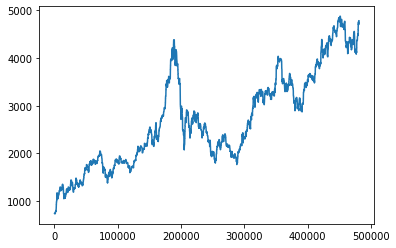

In [20]:
plt.plot(df.index,TA.MAX(df.high,500))

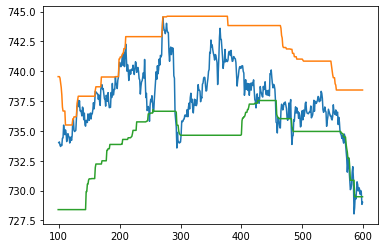

In [21]:
#plt.plot(df.index[:600],TA.MIN(df.low,500)[:600])
#plt.plot(df.index[:600],TA.MAX(df.low,500)[:600])
plt.plot(df.index[100:600],df.close[100:600])
plt.plot(df.index[:600],TA.MAX(df.high,100)[:600])
plt.plot(df.index[:600],TA.MIN(df.high,100)[:600])

## 构建模型

In [35]:
df.Type.value_counts()

0.0    360033
1.0     82784
2.0     82784
Name: Type, dtype: int64

In [7]:
df.columns.to_list()

['Time',
 'Value',
 'Type',
 'PrevExt',
 'time',
 'high',
 'low',
 'open',
 'close',
 'volume',
 'atr',
 'target',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116']

In [8]:
features_columns =[str(i) for i in range(117)]

In [9]:
import copy 
all_feature= copy.deepcopy(features_columns)
all_feature.append("Type")

In [10]:
test_df=df[all_feature]
test_df=test_df.dropna()

In [11]:
test_df["Type"]=test_df["Type"].astype(int)

In [12]:
test_df.Type.value_counts()

0    310647
1     24318
2     24317
Name: Type, dtype: int64

In [13]:
import numpy as np
from scipy import optimize
from scipy import special
import pandas as pd
import numpy as np
from datetime import datetime
import random
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib as TA
import gc
import optuna
from optuna import Trial
from scipy import optimize
from scipy import special
from sklearn.model_selection import TimeSeriesSplit
from scipy.misc import derivative
import seaborn as sns
def sigmoid(x): 
    return 1./(1. +  np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-6)
def focal_loss_lgb(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    # N observations x num_class arrays
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1,num_class, order='F')
    # alpha and gamma multiplicative factors with BCEWithLogitsLoss
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    # flatten in column-major (Fortran-style) order
    return grad.flatten('F'), hess.flatten('F')
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1, num_class, order='F')
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # a variant can be np.sum(loss)/num_class
    return 'focal_loss', np.mean(loss), False

In [14]:
focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 2., 3)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.25, 2., 3)

In [15]:



def fit_lgbm(trial, train, val, devices=(0,), seed=None, cat_features=None, num_rounds=1500):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    ## import for metric and params search 
    metric= {'multi_error'} 
    params = {
         'objective': 'multiclass',
        #'objective':'binary',
        "num_class":3,
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate':trial.suggest_uniform('learning_rate', 0.01, 0.15),
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 10.0),
        "bagging_freq": trial.suggest_int('bagging_freq', 1, 10),
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        "metric":metric,
        "verbosity": -1,
        "max_bin":15,
        "gpu_use_dp":False,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu'})

    params['seed'] = seed

    early_stop = 1000
    verbose_eval = 1000

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_valid, label=y_valid)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      fobj=focal_loss,
                      feval=eval_error)

    
    # predictions
    #y_pred_valid = np.argmax(model.predict(X_valid, num_iteration=model.best_iteration),axis=1)
    #valid_score = precision_score(y_valid,y_pred_valid,average="macro")
    print('best_score', model.best_score)
    log = {'train_loss': model.best_score['training']['multi_error'],
           'valid_loss': model.best_score['valid_1']['multi_error']}
    return model, log

def objective(trial: Trial, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 42
    shuffle = False
    kf = TimeSeriesSplit(n_splits=folds,max_train_size=None)

    X_train = test_df[features_columns]
    y_train = np.array(test_df["Type"])
    print(len(X_train),len(y_train))
    #y_valid_pred_total = np.zeros(X_train.shape[0])
    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, log = fit_lgbm(trial, train_data, valid_data,
                                            num_rounds=5000)
        #y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log['valid_loss']
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return models,valid_score
    else:
        return valid_score

In [16]:
study = optuna.create_study()
study.optimize(objective, n_trials=8)

[I 2022-01-07 21:32:29,044] A new study created in memory with name: no-name-99857b03-22c9-4493-b55f-6cedde3379de


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.0314118	training's focal_loss: 0.00894524	valid_1's multi_error: 0.124031	valid_1's focal_loss: 0.0248481
Early stopping, best iteration is:
[251]	training's multi_error: 0.0898935	training's focal_loss: 0.0162745	valid_1's multi_error: 0.123614	valid_1's focal_loss: 0.0234309
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.08989345713236031), ('focal_loss', 0.016274506088962016)]), 'valid_1': OrderedDict([('multi_error', 0.12361389445557783), ('focal_loss', 0.023430898787351658)])})


[I 2022-01-07 21:36:02,783] Trial 0 finished with value: 0.12361389445557783 and parameters: {'max_depth': 10, 'learning_rate': 0.14475180642984628, 'lambda_l1': 2.2859407433274264, 'lambda_l2': 0.2938945607773354, 'bagging_freq': 4, 'bagging_fraction': 0.8558573306054031, 'feature_fraction': 0.46744898371142096}. Best is trial 0 with value: 0.12361389445557783.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.108948	training's focal_loss: 0.0195215	valid_1's multi_error: 0.123781	valid_1's focal_loss: 0.0233507
[2000]	training's multi_error: 0.0995959	training's focal_loss: 0.0176856	valid_1's multi_error: 0.123447	valid_1's focal_loss: 0.0233803
Early stopping, best iteration is:
[1288]	training's multi_error: 0.105892	training's focal_loss: 0.0188975	valid_1's multi_error: 0.12328	valid_1's focal_loss: 0.0233097
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.10589158678734845), ('focal_loss', 0.01889754797405065)]), 'valid_1': OrderedDict([('multi_error', 0.12327989311957248), ('focal_loss', 0.023309657309470575)])})


[I 2022-01-07 21:41:56,411] Trial 1 finished with value: 0.12327989311957248 and parameters: {'max_depth': 3, 'learning_rate': 0.12325065906416498, 'lambda_l1': 3.6707391809092633, 'lambda_l2': 7.025859319149827, 'bagging_freq': 8, 'bagging_fraction': 0.8575673714756786, 'feature_fraction': 0.34333109057866484}. Best is trial 1 with value: 0.12327989311957248.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.0807755	training's focal_loss: 0.014742	valid_1's multi_error: 0.122545	valid_1's focal_loss: 0.0232846
Early stopping, best iteration is:
[729]	training's multi_error: 0.0927658	training's focal_loss: 0.0164744	valid_1's multi_error: 0.123029	valid_1's focal_loss: 0.0231982
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.09276577268628303), ('focal_loss', 0.016474381086434467)]), 'valid_1': OrderedDict([('multi_error', 0.12302939211756847), ('focal_loss', 0.02319815571028832)])})


[I 2022-01-07 21:46:42,498] Trial 2 finished with value: 0.12302939211756847 and parameters: {'max_depth': 6, 'learning_rate': 0.039760376865514646, 'lambda_l1': 0.4252979474436213, 'lambda_l2': 6.083053751186973, 'bagging_freq': 2, 'bagging_fraction': 0.6892219257085307, 'feature_fraction': 0.7745953906987427}. Best is trial 2 with value: 0.12302939211756847.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.108497	training's focal_loss: 0.0191133	valid_1's multi_error: 0.127104	valid_1's focal_loss: 0.0237563
[2000]	training's multi_error: 0.0892923	training's focal_loss: 0.0158918	valid_1's multi_error: 0.124833	valid_1's focal_loss: 0.0237241
Early stopping, best iteration is:
[1552]	training's multi_error: 0.0972078	training's focal_loss: 0.0171786	valid_1's multi_error: 0.124933	valid_1's focal_loss: 0.0236755
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.09720784208944257), ('focal_loss', 0.017178636402306303)]), 'valid_1': OrderedDict([('multi_error', 0.12493319973279893), ('focal_loss', 0.02367553701300089)])})


[I 2022-01-07 21:53:42,407] Trial 3 finished with value: 0.12493319973279893 and parameters: {'max_depth': 8, 'learning_rate': 0.014378994747147985, 'lambda_l1': 0.3395933970607561, 'lambda_l2': 1.3461185559518836, 'bagging_freq': 8, 'bagging_fraction': 0.3316538520421012, 'feature_fraction': 0.7168397522499667}. Best is trial 2 with value: 0.12302939211756847.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.122958	training's focal_loss: 0.0218997	valid_1's multi_error: 0.129259	valid_1's focal_loss: 0.023936
[2000]	training's multi_error: 0.113657	training's focal_loss: 0.0202221	valid_1's multi_error: 0.124916	valid_1's focal_loss: 0.023371
[3000]	training's multi_error: 0.107395	training's focal_loss: 0.0190489	valid_1's multi_error: 0.123547	valid_1's focal_loss: 0.0231927
[4000]	training's multi_error: 0.102034	training's focal_loss: 0.0180754	valid_1's multi_error: 0.122528	valid_1's focal_loss: 0.0231389
Early stopping, best iteration is:
[3504]	training's multi_error: 0.104288	training's focal_loss: 0.0185351	valid_1's multi_error: 0.122996	valid_1's focal_loss: 0.0231275
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.10428843392004275), ('focal_loss', 0.018

[I 2022-01-07 22:05:14,898] Trial 4 finished with value: 0.12299599198396793 and parameters: {'max_depth': 3, 'learning_rate': 0.026643044728396563, 'lambda_l1': 0.35656576831502135, 'lambda_l2': 4.2748769455763, 'bagging_freq': 6, 'bagging_fraction': 0.9067290765355682, 'feature_fraction': 0.5465923458098563}. Best is trial 4 with value: 0.12299599198396793.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.0559601	training's focal_loss: 0.0118484	valid_1's multi_error: 0.127255	valid_1's focal_loss: 0.027351
Early stopping, best iteration is:
[272]	training's multi_error: 0.10514	training's focal_loss: 0.0188884	valid_1's multi_error: 0.128006	valid_1's focal_loss: 0.02458
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.1051401088807989), ('focal_loss', 0.01888844662406906)]), 'valid_1': OrderedDict([('multi_error', 0.1280060120240481), ('focal_loss', 0.024579958735414187)])})


[I 2022-01-07 22:08:44,757] Trial 5 finished with value: 0.1280060120240481 and parameters: {'max_depth': 9, 'learning_rate': 0.06153987144940993, 'lambda_l1': 0.41652339619755774, 'lambda_l2': 0.16793803726761455, 'bagging_freq': 6, 'bagging_fraction': 0.20397314474033232, 'feature_fraction': 0.956161385558168}. Best is trial 4 with value: 0.12299599198396793.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.0884239	training's focal_loss: 0.0156886	valid_1's multi_error: 0.124065	valid_1's focal_loss: 0.0236546
Early stopping, best iteration is:
[783]	training's multi_error: 0.0971911	training's focal_loss: 0.0170016	valid_1's multi_error: 0.124449	valid_1's focal_loss: 0.0235071
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.09719114258040813), ('focal_loss', 0.017001620078205104)]), 'valid_1': OrderedDict([('multi_error', 0.12444889779559118), ('focal_loss', 0.023507065624096633)])})


[I 2022-01-07 22:13:32,246] Trial 6 finished with value: 0.12444889779559118 and parameters: {'max_depth': 5, 'learning_rate': 0.03508521893060538, 'lambda_l1': 0.26558560338203074, 'lambda_l2': 1.2340593502744541, 'bagging_freq': 6, 'bagging_fraction': 0.5193837603799337, 'feature_fraction': 0.9284242548220755}. Best is trial 4 with value: 0.12299599198396793.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.205421	training's focal_loss: 0.0952466	valid_1's multi_error: 0.205377	valid_1's focal_loss: 0.0965754
Early stopping, best iteration is:
[48]	training's multi_error: 0.142614	training's focal_loss: 0.0991792	valid_1's multi_error: 0.14023	valid_1's focal_loss: 0.099283
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.14261380715406968), ('focal_loss', 0.09917918572826001)]), 'valid_1': OrderedDict([('multi_error', 0.14023046092184369), ('focal_loss', 0.09928301753334415)])})


[I 2022-01-07 22:16:00,920] Trial 7 finished with value: 0.14023046092184369 and parameters: {'max_depth': 10, 'learning_rate': 0.012528620454054677, 'lambda_l1': 0.18140693252116957, 'lambda_l2': 5.626164044920143, 'bagging_freq': 10, 'bagging_fraction': 0.14161834346057545, 'feature_fraction': 0.11173907485049067}. Best is trial 4 with value: 0.12299599198396793.


In [17]:
study.best_params

{'max_depth': 3,
 'learning_rate': 0.026643044728396563,
 'lambda_l1': 0.35656576831502135,
 'lambda_l2': 4.2748769455763,
 'bagging_freq': 6,
 'bagging_fraction': 0.9067290765355682,
 'feature_fraction': 0.5465923458098563}

In [25]:
params={'max_depth': 9,
 'learning_rate': 0.018930251420317103,
 'lambda_l1': 0.807957295078728,
 'lambda_l2': 0.2700357190220375,
 'bagging_freq': 7,
 'bagging_fraction': 0.8804652382109686,
 'feature_fraction': 0.8513238990999246}

In [ ]:
 models0,valid_score = objective(optuna.trial.FixedTrial(params), fast_check=False, target_meter=0, return_info=True)

359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.0978257	training's focal_loss: 0.0174404	valid_1's multi_error: 0.123514	valid_1's focal_loss: 0.0232121
[2000]	training's multi_error: 0.073578	training's focal_loss: 0.0137547	valid_1's multi_error: 0.122144	valid_1's focal_loss: 0.0232524
Early stopping, best iteration is:
[1217]	training's multi_error: 0.0923984	training's focal_loss: 0.0165015	valid_1's multi_error: 0.123347	valid_1's focal_loss: 0.0231579
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.09239838348752547), ('focal_loss', 0.016501524447559698)]), 'valid_1': OrderedDict([('multi_error', 0.12334669338677355), ('focal_loss', 0.023157904216555766)])})
train 119762 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds


In [68]:
for i in range(len(models0)):
    models0[i].save_model("lightgbmeth_"+str(i)+".txt")

In [ ]:
len(features_columns)